# Demystifying Neural Networks

<a id="toc"></a>
## Table of Contents
1. [Introduction](#intro)
2. [Reading in the data](#input)
3. [Choice of model](#model_choice)
4. [Helper Function Definitions](#funct_defn)
5. [Weight Initializations](#layer_and_weights)
6. [Forward Propagation](#forward_propagation)
7. [Back Propagation](#back_propagation)
8. [Update the parameters](#update)
9. [Neural Network Model Definition](#nn_model_defn)
10. [Predict Output](#predict)
11. [Putting Everything Together](#together)<br>
    11.1. [Variation of Cost with Number of Iterations](#variation)<br>
    11.2. [Accuracy on the Test Set](#accuracy_test_set)<br>

<a id="intro"></a>
## 1. [Introduction](#toc)

In this notebook, we will attempt to train a two-layer neural network to identify correctly the handwritten digit. While the images of the dataset will comprise only a single handwritten digit, it will go a long way in illustrating the power of a shallow neural network and lay the groundwork for moving to more complex and interesting applications of this technology. And now lets get started!

<a id = 'input'></a>
## 2. [Reading in the data](#toc)

The first task is to import utf-8 encoded data, decompress it and store it in a numpy array of the correct dimensions. There are supposed to be 60000 examples in the training set and 10000 examples in the test set. 

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
def load_data():
    """
    This function returns training and test features and labels
    Arguments: None
    Returns: training_images, training_labels, test_images, test_labels
    """
    import gzip
    with open("./Data/train-images-idx3-ubyte.gz", 'rb') as f:
        data = f.read()
        training_images = np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()
        
    with open("./Data/train-labels-idx1-ubyte.gz", 'rb') as f:
        data = f.read()
        training_labels = np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()
    
    with open("./Data/t10k-images-idx3-ubyte.gz", 'rb') as f:
        data = f.read()
        test_images = np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()
    with open("./Data/t10k-labels-idx1-ubyte.gz", 'rb') as f:
        data = f.read()
        test_labels = np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()   
    
    return training_images[16:].reshape((-1,28,28)), np.squeeze(training_labels[8:]), test_images[16:].reshape((-1,28,28)), np.squeeze(test_labels[8:])

In [7]:
training_images, training_labels, test_images, test_labels = load_data()
print(training_images.shape)
print(training_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(47040016,)
(60008,)
(7840016,)
(10008,)


I'll first validate the data that has been read to confirm that indeed the data is in the form that I expect it to be in (need to do this since the original data wasn't exactly divisible by 784 which led me to drop the first few pixel values and also dropped the first few values of labels as evident from the function I have written. This is just a sanity check to ensure that the dropped pixels and labels don't cause any shift in the pixel values that belong to a particular example)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
Number of unique pixel values in the training set:256
Number of unique pixel values in the test set:256
Number of unique labels in training set:10
Number of unique labels in test set:10


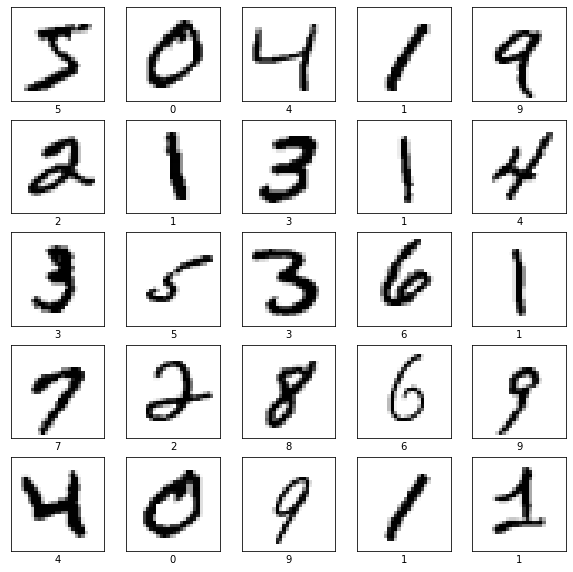

In [4]:
print(training_images.shape)
print(training_labels.shape)
print(test_images.shape)
print(test_labels.shape)

training_images = training_images[:1000]
training_labels = training_labels[:1000]
test_images = test_images[:200]
test_labels = test_labels[:200]

print(f'Number of unique pixel values in the training set:{len(np.unique(training_images.reshape((training_images.shape[0], -1))))}')
print(f'Number of unique pixel values in the test set:{len(np.unique(test_images.reshape((test_images.shape[0], -1))))}')
print(f'Number of unique labels in training set:{len(np.unique(training_labels))}\nNumber of unique labels in test set:{len(np.unique(test_labels))}')

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i], cmap=plt.cm.binary)
    plt.xlabel(training_labels[i])


Aaand its a resounding yes! We can now proceed to the next step in our deep learning journey and that is deciding on the model. We will also have to reshape the images in the datasets to one dimensional vectors instead of the two-dimensional form they are in now (why didn't we do this earlier? - because I wanted to be sure that everything was matching up)<br>
Note that henceforth we will be taking a subset of the training and test data since that is more than sufficient for the application we are using the data for.

<a id = "model_choice"></a>
## 3. [Choice of model](#toc)

Now here's the tricky bit! Since its a 2 layer Neural Network that we're confined to, the one hyperparameter we can play around with is the number of units in each hidden layer. It might need a fair bit of tuning to arrive at a combination that is optimal for our application.
**<p style="text-align: center;">Proposed Architecture for Neural Network</p>**

![Proposed Architecture](Images/proposed_architecture.png)

Now that we have the general architecture ready, we can proceed to the specifics

We will set:
1. Learning rate $\alpha$ of 0.1
2. Number of units in hidden layer (n<sup>[1]</sup>)as 512
3. Number of iterations or epochs as 500
4. Hidden layer activation function is taken as the relu function
5. Output layer activation function is the softmax function 

<a id = 'funct_defn'></a>
## 4. [Helper Function Definitions](#toc)

Here we will define certain common functions that will prove to be useful during the forward and backward propagation steps of training the neural network
The functions that we will define in this section are:
1. Flatten and reshape Training and Test features
2. One hot vector representation for Y
3. Sigmoid Activation Function (as well as derivative and cost function for backpropagation)
4. Tanh function(as well as derivative for backpropagation)
5. Relu function (as well as derivative for backpropagation)
5. Softmax Function

In [5]:
def reshape_X(X):
    """
    Reshape training and test features and convert each example from two to one-dimensional form
    Arguments: Training or test data
    Returns: Vector containing flattened examples
    """
    return X.reshape(X.shape[0], -1).T/255

def one_hot_encoding(Y):
    """
    Convert labels to its appropriate one-hot encoding representation
    Arguments: training or test labels
    Returns: One-hot representation of labels in appropriate format
    """
    shape = (len(Y), Y.max() + 1)
    one_hot_Y = np.zeros(shape)
    rows = np.arange(Y.size)
    one_hot_Y[rows, Y] = 1
    return one_hot_Y.T

def sigmoid(z):
    """
    Sigmoid activation function implementation
    Arguments: Linear function that is to be converted to a non-linear form
    Returns: Sigmoid vector
    """
    s = 1/(1 + np.exp(-z))
    return s

def relu(z):
    """
    ReLU activation function implementation
    Arguments: Linear function that is to be converted to a non-linear form
    Returns: ReLU vector
    """
    r = np.maximum(0,z)
    return r

def tanh(z):
    """
    Tanh activation function implementation
    Arguments: Linear function that is to be converted to a non-linear form
    Returns: Tanh vector
    """
    exp1 = np.exp(z)
    exp2 = np.exp(-z)
    t = (exp1 - exp2)/(exp1 + exp2)
    return t

def softmax(z):
    """
    Softmax activation function implementation
    Arguments: Linear function that is to be converted to a non-linear form
    Returns: Softmax vector
    """
    e_x = np.exp(z- np.max(z))
    softmax = e_x/np.sum(e_x, axis = 0, keepdims = True)
    return softmax

def sigmoid_prime(z):
    """
    The first derivative of the sigmoid activation layer
    Arguments: Two options: one using A and the other using Z. We have chosen the one using Z since that is assumed to be passed between the forward and backward propagation step
    Returns: The first derivative of the activation function vector with respect to Z
    """
    s_prime = np.exp(-z)/(1+np.exp(-z))**2
    return s_prime

def relu_prime(z):
    """
    The first derivative of the relu activation layer
    Arguments: Two options: one using A and the other using Z. We have chosen the one using Z since that is assumed to be passed between the forward and backward propagation step
    Returns: The first derivative of the activation function vector with respect to Z
    """
    r_prime = (z > 0) * 1
    return r_prime

def tanh_prime(z):
    """
    The first derivative of the tanh activation layer
    Arguments: Two options: one using A and the other using Z. We have chosen the one using Z since that is assumed to be passed between the forward and backward propagation step
    Returns: The first derivative of the activation function vector with respect to Z
    """
    t_prime = 1 -((tanh(z))**2)
    return t_prime

def softmax_prime(z):
    """
    The first derivative of the softmax activation layer
    Arguments: Two options: one using A and the other using Z. We have chosen the one using Z since that is assumed to be passed between the forward and backward propagation step
    Returns: The first derivative of the activation function vector with respect to Z
    """
    signal = softmax(z)
    softmax_prime = np.multiply( signal, 1 - signal ) + sum(- signal * np.roll( signal, i, axis = 1 ) for i in range(1, signal.shape[1] ))
    return softmax_prime

def softmax_loss_function(A, Y):
    """
    Loss function for the output layer
    Arguments: Output vector of the softmax and one-hot encoded Y
    Returns: Loss vector for softmax activation layer
    """
#     loss = -np.sum(np.dot(Y, np.log(A).T))/Y.shape[1]
    loss = -np.sum(np.sum(Y * np.log(A), axis = 1))/Y.shape[1]
    return loss

def sigmoid_loss_function(A, Y):
    """
    Loss function for the output layer
    Arguments: Output vector of the softmax and one-hot encoded Y
    Returns: Loss vector for softmax activation layer
    """
    loss = -np.sum(Y * np.log(A) + (1-Y)*np.log(1-A), axis = 1)/Y.shape[1]
    return loss

<a id = 'layer_and_weights'></a>
## 5. [Weight Initialization](#toc)

In this section, we will define the number of layers and number of units in each layer and initialize the weights and biases corresponding to each layer

In [6]:
def initialize_parameters(layer_units):
    """
    Initialize the weights and biases of the different layers in the neural network
    Arguments: List containing the number of units in each layer as well as the number of features in the input layer
    Returns: Dictionary containing parameters corresponding to the different layers in the neural network
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_units)
    for i in range(1,L):
        parameters["W"+str(i)] = np.random.randn(layer_units[i], layer_units[i-1]) * 0.01
        parameters["b"+str(i)] = np.random.randn(layer_units[i], 1) * 0.01
    return parameters

<a id = 'forward_propagation'></a>
## 6. [Forward Propagation](#toc)

In this section we will define all functions that will be helpful during forward propagation

In [7]:
def forward_propagation_linear(A_prev, W, b):
    """
    Computes the value of Z - the input to the activation function
    Arguments: The activations from the previous layer and the weights and biases of the current layer
    """
    Z = np.dot(W, A_prev) + b
    return Z

def forward_propagation_activation(A_prev,W, b, activation = "sigmoid"):
    """
    Converts linear function to a non-linear form as per activation function chosen
    Arguments: Linear vector output from perceptron and choice of activation function
    Returns: Activation vector of the layer
    """
    if activation=="sigmoid":
        Z = forward_propagation_linear(A_prev, W, b)
        A = sigmoid(Z)
    elif activation=="softmax":
        Z = forward_propagation_linear(A_prev, W, b)
        A = softmax(Z)
    elif activation=="tanh":
        Z = forward_propagation_linear(A_prev, W, b)
        A = tanh(Z)
    elif activation=="relu":
        Z = forward_propagation_linear(A_prev, W, b)
        A = relu(Z)
        
    cache = {"Z":Z, "A_prev":A_prev, "W": W, "b":b, "activation": activation}
    return A, cache

def forward_propagation_model(X_train, parameters, activations_list):
    """
    The complete forward propagation step
    Arguments: Input Training features, the parameters corresponding to each layer and a list containing activation functions for each layer
    Returns: Activation of the final layer as well the caches (defined in forward_propagation_activation function) list
    """
    L = len(parameters) - 1
    caches = []
    A = X_train
    for i in range(1, L):
        A_prev = A
        A, cache = forward_propagation_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], activations_list[i-1])
        caches.append(cache)
        
    return A, caches

Before moving to implement back-propagation, we need to ensure that the functions defined above work as intended

In [8]:
# Reshape training_images
training_images_flatten = reshape_X(training_images)

# Convert training_labels to one hot encoding format
training_labels_one_hot = one_hot_encoding(training_labels)

# Initialise parameters
parameters = initialize_parameters([training_images_flatten.shape[0], 512, 10])

AL, caches = forward_propagation_model(training_images_flatten, parameters, ["relu", "softmax"])

cost = softmax_loss_function(AL, training_labels_one_hot)
print(cost)

2.302116721777529


Thus begins our journey to reduce this cost vector.

<a id = "back_propagation"></a>
## 7. [Back Propagation](#toc)

In this section we will define the essential functions that we'll be using in the back propagation step.

In [9]:
def back_propagation_linear(dZ, A_prev, W, b):
    """
    Calculate the derivative of the loss function with respect to the activation, weights and biases that can be used in gradient descent
    Arguments: Derivative of linear function (Z) of the current layer, activation vector of the previous layer, weights and biases of the current layer
    Returns: Derivative wrt activation of the previous layer, derivative wrt weights and biases of the current layer
    """
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis =1, keepdims = True)/m
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def back_propagation_activation(dA, Z, A_prev, W, b, activation_function = "sigmoid"):
    """
    Calculate the derivative of the loss function with respect to the activation, weights and biases that can be used in gradient descent
    Arguments: Derivative wrt activation function of the current layer, linear function (Z) of the current layer, activation vector of the previous layer, weights and biases of the current layer and the activation function of the current layer 
    Returns: Derivative wrt activation of the previous layer, derivative wrt weights and biases of the current layer
    """
    m = A_prev.shape[1]
    if activation_function == "sigmoid":
        dZ = dA * sigmoid_prime(Z)
        dA_prev, dW, db = back_propagation_linear(dZ, A_prev, W, b)
    elif activation_function == "relu":
        dZ = dA * relu_prime(Z)
        dA_prev, dW, db = back_propagation_linear(dZ, A_prev, W, b)
    elif activation_function == "tanh":
        dZ = dA * tanh_prime(Z)
        dA_prev, dW, db = back_propagation_linear(dZ, A_prev, W, b)
    elif activation_function == "softmax":
        dZ = dA * softmax_prime(Z)
        dA_prev, dW, db = back_propagation_linear(dZ, A_prev, W, b)
    
    return dA_prev, dW, db

def back_propagation_model(AL, Y, caches):
    """
    Computes the gradient dictionary of all the layers in the network
    Arguments: Activation vector of the final layer, labels in one hot encoding and the cache list
    Returns: The gradients of the different layers in the network
    """
    gradients = {}
    L = len(caches)
    if caches[L-1]["activation"] == "sigmoid":
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        gradients["dA"+str(L-1)], gradients["dW"+str(L)], gradients["db"+str(L)] = back_propagation_activation(dA = dAL,
                                                                                                               Z = caches[L-1]["Z"],
                                                                                                               A_prev = caches[L-1]["A_prev"],
                                                                                                               W = caches[L-1]["W"],
                                                                                                               b = caches[L-1]["b"], 
                                                                                                               activation_function=caches[L-1]["activation"])
    elif caches[L-1]["activation"] == "softmax":
        dZL = AL - Y
        gradients["dA"+str(L-1)], gradients["dW"+str(L)], gradients["db"+str(L)] = back_propagation_linear(dZ = dZL,
                                                                                                           A_prev = caches[L-1]["A_prev"],
                                                                                                           W = caches[L-1]["W"],
                                                                                                           b = caches[L-1]["b"])
    for l in reversed(range(L-1)):
        cache =  caches[l]
        gradients["dA"+str(l)], gradients["dW"+str(l+1)], gradients["db"+str(l+1)] = back_propagation_activation(gradients["dA"+str(l+1)],
                                                                                                              cache["Z"],
                                                                                                              cache["A_prev"],
                                                                                                              cache["W"],
                                                                                                              cache["b"],
                                                                                                              cache["activation"])
        
    return gradients

<a id='update'></a>
## 8. [Update the parameters](#toc)

Here we will define the function to update the weights and biases in each layer as per the gradients computed in the back propagation step.

In [10]:
def update_parameters(parameters, gradients, learning_rate):
    """
    Update the weights and biases using the gradients from the back propagation step
    Arguments: Parameters of all the layers, Gradients from all the layers and the learning_rate
    Returns: Updated value of parameters that moves to minimize the cost function
    """
    for i in range(1, len(parameters)-1):
        parameters["W"+str(i)] = parameters["W"+str(i)] - (learning_rate * gradients["dW"+str(i)])
        parameters["b"+str(i)] = parameters["b"+str(i)] - (learning_rate * gradients["db"+str(i)])
        
    return parameters

We will write a small function to test the accuracy of the model so as to confirm movement in the correct direction

In [11]:
def accuracy_score(AL, labels = training_labels):
    """
    Computes the accuracy of the predictions wrt the labels
    Arguments: Activations from the final layer and training labels
    Returns: Accuracy score in percentage
    """
    AL_to_numbers = np.argmax(AL, axis = 0)
    accuracy = np.sum(AL_to_numbers == labels)/labels.shape[0]
    return accuracy * 100

<a id = 'nn_model_defn'></a>
## 9. [Neural Network Model Definition](#toc)

We've arrived!! Well atleast almost. All that remains is to combine the different functions we have defined in the course of this notebook to form the neural network model and viola! - we'll have what we were looking for.

In [12]:
def neural_network_model(training_images, training_labels, layer_units, activations_list, learning_rate = 0.1, num_iterations = 500):
    """
    Combines all the helper function to realise the neural network as per inputs provided
    Arguments: Training features and labels, number of units in each layer, type of activation function in each layer, learning rate and number of iterations
    Returns: Accuracies, costs and updated parameters
    """
    # Reshape training_images
    training_images_flatten = reshape_X(training_images)

    # Convert training_labels to one hot encoding format
    training_labels_one_hot = one_hot_encoding(training_labels)

    # Initialise parameters
    parameters = initialize_parameters(layer_units)
    costs = []
    accuracies = []
    for i in tqdm(range(num_iterations)):
        AL, caches = forward_propagation_model(training_images_flatten, parameters, activations_list)
        accuracy = accuracy_score(AL, training_labels)
        if activations_list[len(activations_list)-1] =="softmax":
            cost = softmax_loss_function(AL, training_labels_one_hot)
        elif activations_list[len(activations_list)-1] =="sigmoid":
            cost = sigmoid_loss_function(AL, training_labels_one_hot)

        costs.append(cost)
        
        if i % 100 == 0:
            accuracies.append(accuracy)
        
        gradients = back_propagation_model(AL, training_labels_one_hot,caches)
        parameters = update_parameters(parameters, gradients, learning_rate)
        
    accuracies.append(accuracy)
    return accuracies, costs, parameters

At this stage it would be great to do a sanity check to ensure everything is working properly

In [13]:
layer_units = [reshape_X(training_images).shape[0], 512, 10]
activation_list = ["relu", "softmax"]
learning_rate = 0.1
num_iterations = 250

accuracies, costs, parameters = neural_network_model(training_images, training_labels, layer_units, activation_list, learning_rate, num_iterations)
print('The accuracy on the training set after training is {0:.2f}%'.format(accuracies[len(accuracies)-1]))

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:11<00:00, 20.96it/s]

The accuracy on the training set after training is 92.40%


<a id = "predict"></a>
## 10. [Predict Output](#toc)

In this section, we will define the function to predict the output.

In [14]:
def predict(X_flatten, parameters, activations_list):
    """
    Calculates the activation vector for the test data
    Arguments: Input Features, trained weights and parameters and activations of each layer
    Returns: Predicted number of neural network
    """
    AL, caches = forward_propagation_model(X_flatten, parameters, activations_list)
    AL_to_numbers = np.argmax(AL, axis = 0)
    return AL_to_numbers

In [15]:
predictions = predict(reshape_X(test_images), parameters, activation_list)
accuracy = np.sum(predictions == test_labels)/test_labels.shape[0]
print(f'The accuracy on the test set after training is {accuracy*100}%')

The accuracy on the test set after training is 87.5%


<a id = 'together'></a>
## 11. [Putting Everything Together](#toc)

Which brings us to the final section of the project. Here we will finally train the model on the training set and use it for making predictions on the test set and explore some salient details about the model

In [16]:
layer_units = [reshape_X(training_images).shape[0], 512, 10]
activation_list = ["relu", "softmax"]
learning_rate = 0.1
num_iterations = 500

accuracies, costs, parameters = neural_network_model(training_images, training_labels, layer_units, activation_list, learning_rate, num_iterations)
print('The accuracy on the training set after training is {0:.2f}%'.format(accuracies[len(accuracies)-1]))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.37it/s]

The accuracy on the training set after training is 97.10%


<a id = 'variation'></a>
## 11.1. [Variation of Cost with number of iterations](#toc)

The costs can be plotted to check how they vary per iteration and confirm whether the costs are indeed reducing in general

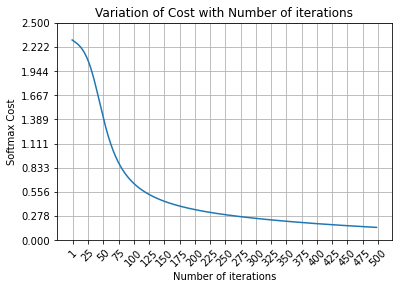

In [17]:
plt.plot(costs)
plt.xlabel("Number of iterations")
ticks = range(1,519, 25)
tick_labels = [str(tick - 1) if tick!=1 else str(tick) for tick in ticks]
plt.xticks(ticks, tick_labels, rotation = 45)
plt.yticks(np.linspace(0,2.5,10))
plt.title("Variation of Cost with Number of iterations")
plt.ylabel('Softmax Cost')
plt.grid()

<a id = 'accuracy_test_set'></a>
## 11.2. [Accuracy on the Test Set](#toc)

Accuracy on the test set is another important metric to confirm that we have not overfitted our model to have high variance and hence the model is not generalizable.

In [18]:
predictions = predict(reshape_X(test_images), parameters, activation_list)
accuracy = np.sum(predictions == test_labels)/test_labels.shape[0]
print(f'The accuracy on the test set after training is {accuracy*100}%')

The accuracy on the test set after training is 91.5%


So we have not overfitted our model on the training data. Also our initial assumptions for learning rate, activation functions, number of units in the layers and number of iterations have yielded some really good results!